In [1]:
import cv2
import os

# Define the path to the directory containing the video files
video_directory = '2023_Cox_sample_videos'

# Define the directory to save the frames
frame_directory = 'images'

# Create the directory if it doesn't already exist
if not os.path.exists(frame_directory):
    os.makedirs(frame_directory)

# Define the frame rate
frame_rate = 5

# Loop over all files in the video directory
for filename in os.listdir(video_directory):
    # Check if the file is a video file
    if filename.endswith('.wmv'):   # You can add checks for other video formats here if needed

        # Create a VideoCapture object
        video = cv2.VideoCapture(os.path.join(video_directory, filename))

        # Check if the video opened successfully
        if not video.isOpened():
            print(f"Error opening video file: {filename}")
            continue

        frame_count = 0

        while video.isOpened():
            # Read a frame from the video
            success, frame = video.read()

            # If the frame was read successfully, save it as an image file
            if success:
                if frame_count % frame_rate == 0:  # This will save one frame every 'frame_rate' frames
                    cv2.imwrite(os.path.join(frame_directory, f'frame{frame_count}.jpg'), frame)
                frame_count += 1
            else:
                break

        # After the loop release the cap object
        video.release()

# Destroy all the windows
cv2.destroyAllWindows()


In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Directory containing all images
base_dir = 'images'

# Directories to save the training and validation data
train_dir = 'train'
val_dir = 'test'

# Create the directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Proportion of data to use for validation
val_ratio = 0.2

# Get list of image file names
image_files = os.listdir(base_dir)

# Split files into training and validation sets
train_files, val_files = train_test_split(image_files, test_size=val_ratio)

# Copy training and validation files into their respective directories
for file in train_files:
    shutil.copy(os.path.join(base_dir, file), os.path.join(train_dir, file))
for file in val_files:
    shutil.copy(os.path.join(base_dir, file), os.path.join(val_dir, file))


In [31]:
'''
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,  # this is the target directory
    target_size=(150, 150),  # all images will be resized to 150x150
    batch_size=20,
    class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
'''

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [3]:
import os
from PIL import Image

# Directory containing images
image_dir = 'images'

# Get list of image file names
image_files = os.listdir(image_dir)

# Open each image and store in a list
images = []
for file in image_files:
    image = Image.open(os.path.join(image_dir, file))
    images.append(image)

# Print the number of images loaded
print(len(images))


6918


In [4]:
import numpy as np
#from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Directory containing images
image_dir = 'images'

# Get list of image file names
image_files = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]


# Resize images and convert to array
image_size = (150, 150)
images_array = np.array([img_to_array(load_img(img_path, target_size=image_size)) for img_path in image_files])

# Normalize pixel values to [0, 1]
images_array = images_array.astype('float32') / 255

# Reshape images into 1D vectors
images_array = images_array.reshape((len(images_array), -1))


In [5]:
from sklearn.cluster import KMeans

# Number of clusters
n_clusters = 5

# Perform K-means clustering
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(images_array)

# Get cluster assignments for each image
cluster_assignments = kmeans.labels_


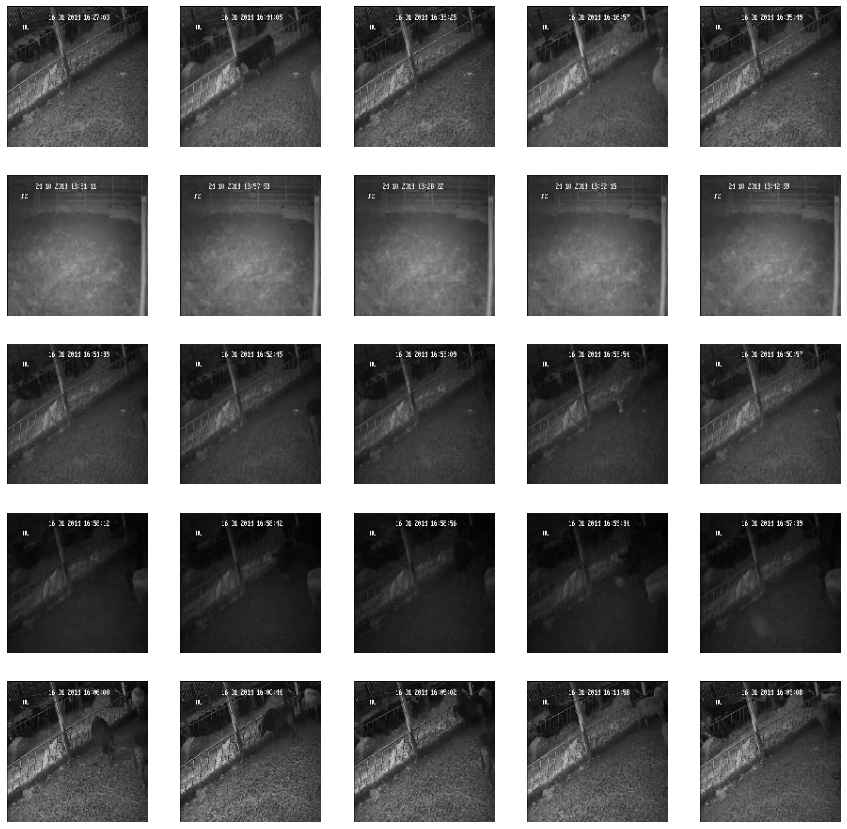

In [6]:
import matplotlib.pyplot as plt
import random

# Number of images to display from each cluster
n_images = 5

# Create a figure to display the images
fig, ax = plt.subplots(n_clusters, n_images, figsize=(n_images * 3, n_clusters * 3))

# For each cluster
for i in range(n_clusters):
    # Get the indices of the images in this cluster
    cluster_indices = np.where(cluster_assignments == i)[0]
    
    # Randomly select n_images indices
    selected_indices = random.sample(list(cluster_indices), n_images)
    
    # For each selected image
    for j, index in enumerate(selected_indices):
        # Load the image
        img = load_img(image_files[index], target_size=image_size)
        
        # Display the image
        ax[i, j].imshow(img)
        ax[i, j].axis('off')

plt.show()


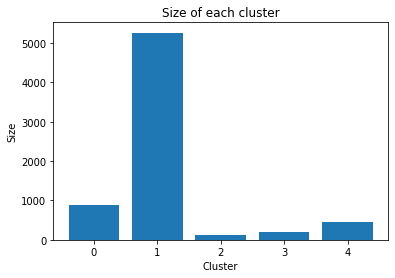

In [7]:
import matplotlib.pyplot as plt

# Calculate the size of each cluster
cluster_sizes = [np.sum(cluster_assignments == i) for i in range(n_clusters)]

# Create a bar chart
plt.bar(range(n_clusters), cluster_sizes)
plt.xlabel('Cluster')
plt.ylabel('Size')
plt.title('Size of each cluster')
plt.show()


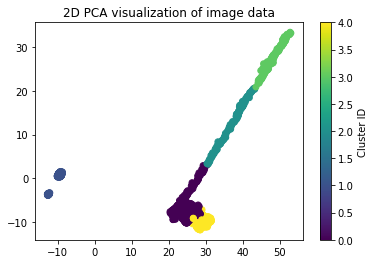

In [8]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
images_2d = pca.fit_transform(images_array)

# Create a scatter plot
plt.scatter(images_2d[:, 0], images_2d[:, 1], c=cluster_assignments, cmap='viridis')
plt.colorbar(label='Cluster ID')
plt.title('2D PCA visualization of image data')
plt.show()


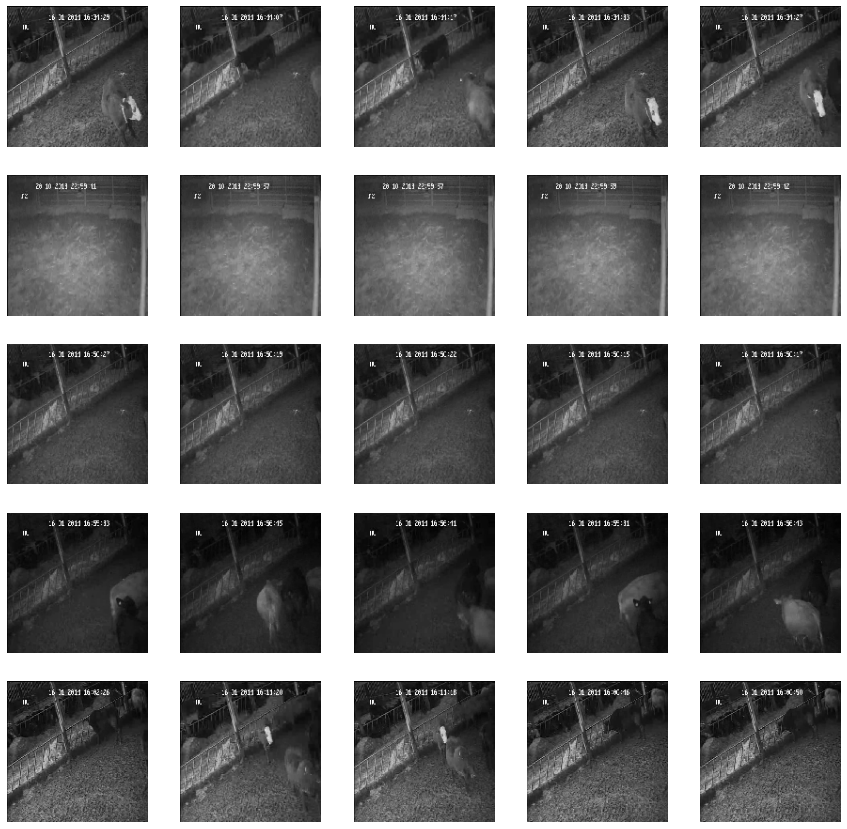

In [9]:
# Number of anomalies to display from each cluster
n_anomalies = 5

# Create a figure to display the images
fig, ax = plt.subplots(n_clusters, n_anomalies, figsize=(n_anomalies * 3, n_clusters * 3))

# For each cluster
for i in range(n_clusters):
    # Get the indices and distances of the images in this cluster
    cluster_indices = np.where(cluster_assignments == i)[0]
    cluster_distances = [np.linalg.norm(images_array[j] - kmeans.cluster_centers_[i]) for j in cluster_indices]
    
    # Find the n_anomalies most distant images
    anomaly_indices = np.argsort(cluster_distances)[-n_anomalies:]
    
    # For each anomaly
    for j, index in enumerate(anomaly_indices):
        # Load the image
        img = load_img(image_files[cluster_indices[index]], target_size=image_size)
        
        # Display the image
        ax[i, j].imshow(img)
        ax[i, j].axis('off')

plt.show()


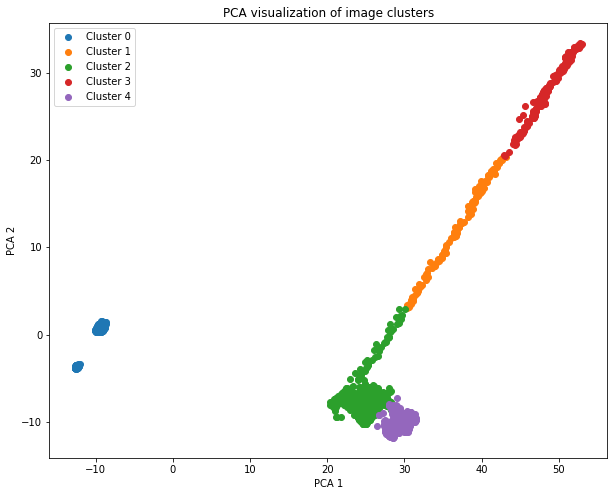

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce the dimensionality of the images to 2D using PCA
pca = PCA(n_components=2)
images_pca = pca.fit_transform(images_array)

# Plot the images based on their PCA values and color by cluster assignment
plt.figure(figsize=(10, 8))
for cluster_id in range(n_clusters):
    plt.scatter(images_pca[cluster_assignments == cluster_id, 0], 
                images_pca[cluster_assignments == cluster_id, 1], 
                label=f'Cluster {cluster_id}')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA visualization of image clusters')
plt.legend()
plt.show()


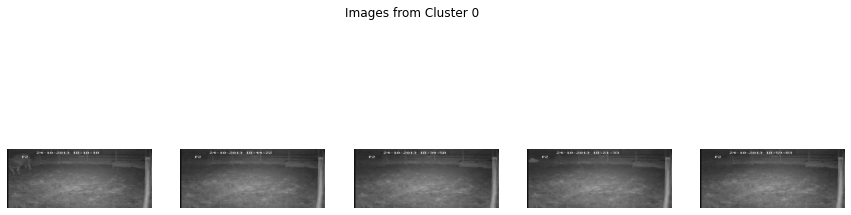

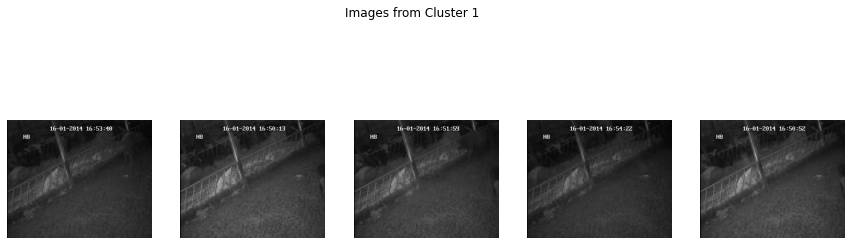

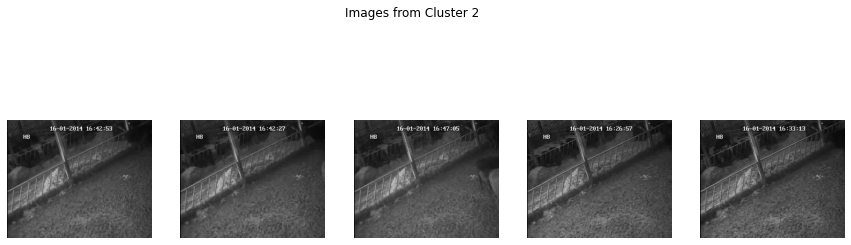

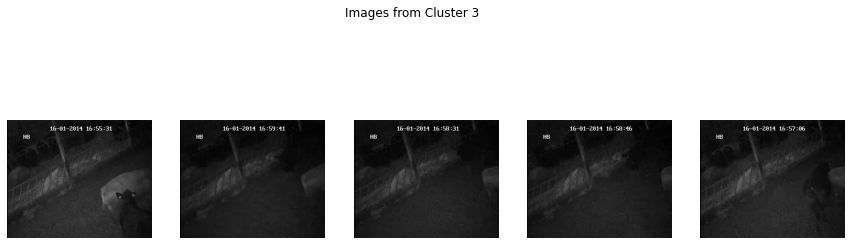

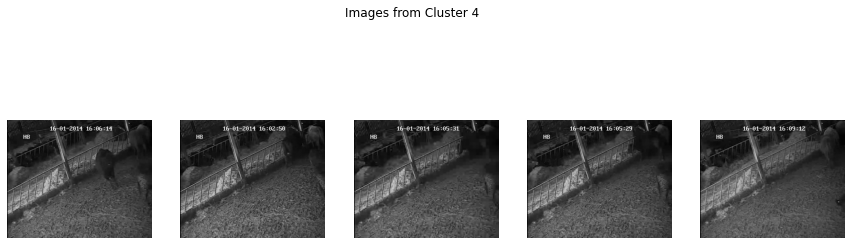

In [14]:
import matplotlib.image as mpimg

# Number of images to display from each cluster
num_images = 5

for cluster_id in range(n_clusters):
    # Get image paths from this cluster
    cluster_images = [image_files[i] for i, assignment in enumerate(cluster_assignments) if assignment == cluster_id]
    
    # Randomly sample images from this cluster
    sampled_images = np.random.choice(cluster_images, num_images, replace=False)
    
    # Display images
    plt.figure(figsize=(15, 5))
    for idx, img_path in enumerate(sampled_images):
        plt.subplot(1, num_images, idx + 1)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Images from Cluster {cluster_id}')
    plt.show()


In [18]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Define the size of encoded representation
encoding_dim = 32  # This is the size of the compressed representation. Adjust as needed.

# Define input layer
input_img = Input(shape=(images_array.shape[1],))

# Define encoding and decoding layers
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(images_array.shape[1], activation='sigmoid')(encoded)

# Build the autoencoder model
autoencoder = Model(input_img, decoded)

# Build the encoder model
encoder = Model(input_img, encoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(images_array, images_array, epochs=5, batch_size=256, shuffle=True, validation_split=0.2)


Epoch 1/5
22/22 [==============================] - 81s 3s/step - loss: 0.6401 - val_loss: 0.5781
Epoch 2/5
22/22 [==============================] - 30s 1s/step - loss: 0.6109 - val_loss: 0.5759
Epoch 3/5
22/22 [==============================] - 32s 1s/step - loss: 0.6090 - val_loss: 0.5652
Epoch 4/5
22/22 [==============================] - 72s 3s/step - loss: 0.6068 - val_loss: 0.5584
Epoch 5/5
22/22 [==============================] - 44s 2s/step - loss: 0.6059 - val_loss: 0.5560


In [19]:
encoded_imgs = encoder.predict(images_array)


217/217 [==============================] - 4s 16ms/step


In [20]:
from sklearn.cluster import KMeans

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5)  # Adjust the number of clusters as needed
cluster_assignments = kmeans.fit_predict(encoded_imgs)


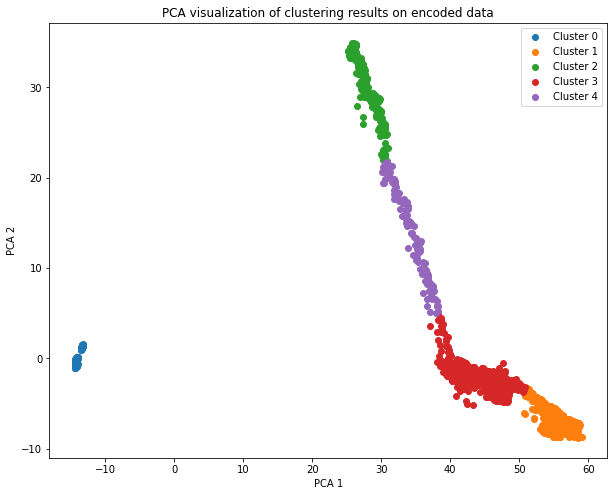

In [21]:
# Visualize the clusters using PCA
pca = PCA(n_components=2)
encoded_pca = pca.fit_transform(encoded_imgs)

plt.figure(figsize=(10, 8))
for cluster_id in range(n_clusters):
    plt.scatter(encoded_pca[cluster_assignments == cluster_id, 0], 
                encoded_pca[cluster_assignments == cluster_id, 1], 
                label=f'Cluster {cluster_id}')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA visualization of clustering results on encoded data')
plt.legend()
plt.show()


In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Define the size of the encoded representation
encoding_dim = 128  # Adjust this value based on your preference

# Define the input layer
input_img = Input(shape=(images_array.shape[1],))

# Define the encoding layers
encoded = Dense(512, activation='relu')(input_img)
encoded = Dense(encoding_dim, activation='relu')(encoded)

# Define the decoding layers
decoded = Dense(512, activation='relu')(encoded)
decoded = Dense(images_array.shape[1], activation='sigmoid')(decoded)

# Build the autoencoder model
autoencoder = Model(inputs=input_img, outputs=decoded)

# Build the encoder model
encoder = Model(inputs=input_img, outputs=encoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
history = autoencoder.fit(images_array, images_array, epochs=5, batch_size=256, shuffle=True, validation_split=0.2)


Epoch 1/5
22/22 [==============================] - 220s 10s/step - loss: 0.0110 - val_loss: 0.0248
Epoch 2/5
22/22 [==============================] - 171s 8s/step - loss: 0.0023 - val_loss: 0.0155
Epoch 3/5
22/22 [==============================] - 162s 8s/step - loss: 8.0759e-04 - val_loss: 0.0129
Epoch 4/5
22/22 [==============================] - 162s 7s/step - loss: 6.1879e-04 - val_loss: 0.0126
Epoch 5/5
22/22 [==============================] - 176s 8s/step - loss: 6.0062e-04 - val_loss: 0.0127


In [24]:
encoded_imgs = encoder.predict(images_array)

217/217 [==============================] - 23s 106ms/step


In [25]:
from sklearn.cluster import KMeans

# Decide on the number of clusters
n_clusters = 5  # Adjust based on your preference or dataset characteristics

# Apply KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_assignments = kmeans.fit_predict(encoded_imgs)


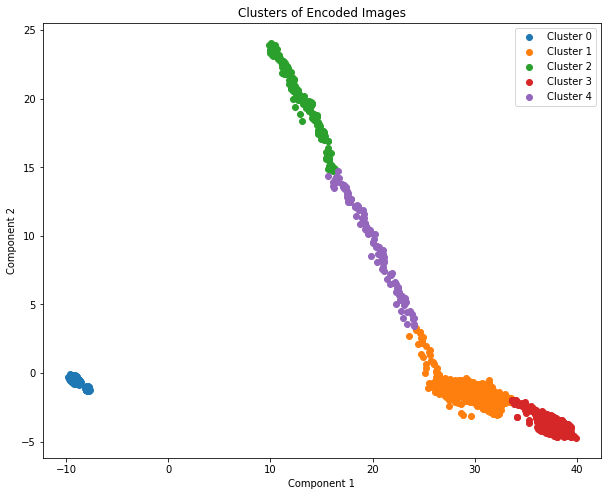

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce the dimensionality of the encoded images to 2D
pca = PCA(n_components=2)
encoded_2d = pca.fit_transform(encoded_imgs)

# Plot the clusters
plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    plt.scatter(encoded_2d[cluster_assignments == i, 0], encoded_2d[cluster_assignments == i, 1], label=f'Cluster {i}')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Clusters of Encoded Images')
plt.legend()
plt.show()


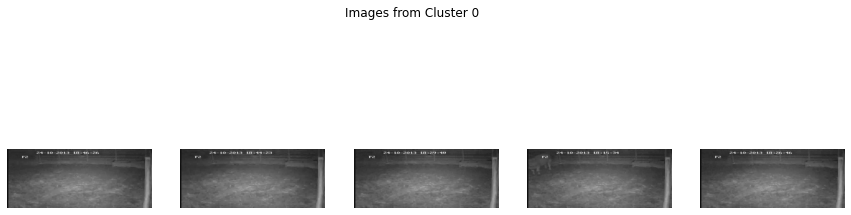

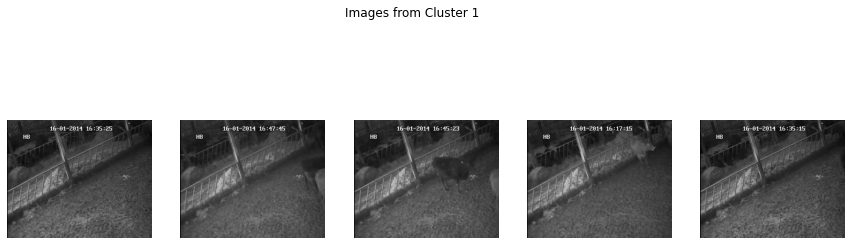

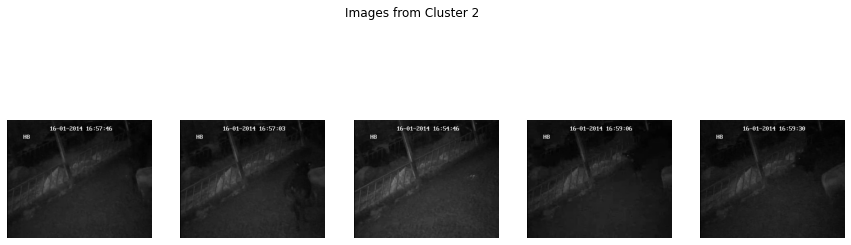

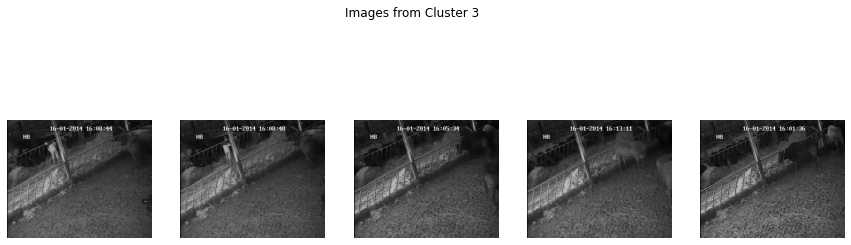

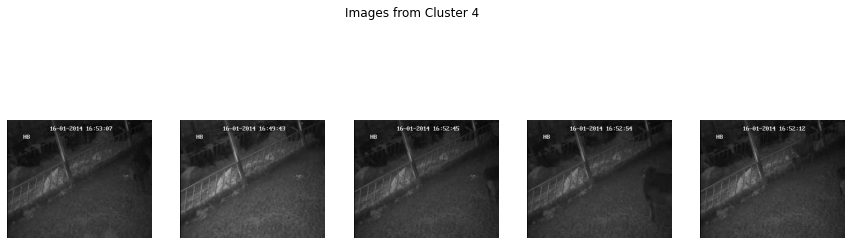

In [27]:
import matplotlib.image as mpimg

# Number of images to display from each cluster
num_images = 5

for cluster_id in range(n_clusters):
    # Get image paths from this cluster
    cluster_images = [image_files[i] for i, assignment in enumerate(cluster_assignments) if assignment == cluster_id]
    
    # Randomly sample images from this cluster
    sampled_images = np.random.choice(cluster_images, num_images, replace=False)
    
    # Display images
    plt.figure(figsize=(15, 5))
    for idx, img_path in enumerate(sampled_images):
        plt.subplot(1, num_images, idx + 1)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Images from Cluster {cluster_id}')
    plt.show()


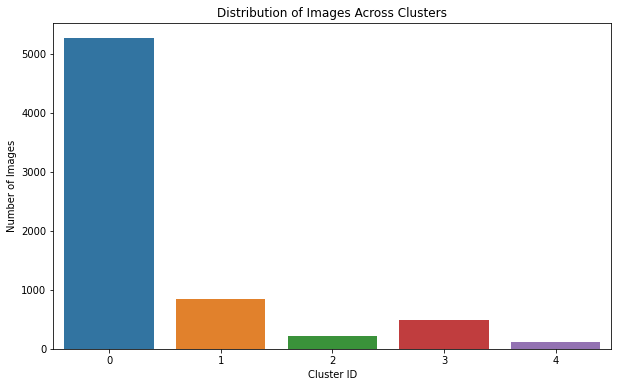

In [28]:
import seaborn as sns

# Count images in each cluster
cluster_sizes = [sum(cluster_assignments == i) for i in range(n_clusters)]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(range(n_clusters)), y=cluster_sizes)
plt.xlabel('Cluster ID')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Clusters')
plt.show()


In [29]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
sil_score = silhouette_score(encoded_imgs, cluster_assignments)

print(f"Silhouette Score: {sil_score:.2f}")


Silhouette Score: 0.91
